# Load synthetic

The load data are obtained from PJM.

'inst_load.csv' stores actual 5min load, 'very_short_load_frcst.csv' stores forecast 5min load, 'are_control_error.csv' stores the ACE every 15s.

All data are in MW.

Synthetic demand data from actual PJM datasets, the output is 'd_syn2.csv'.

Output = Load + ACE

Output contains 3600s of hour 10 and hour 18 in 3600 rows.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import os

In [2]:
dir_path = os.path.abspath('..')
data_path = '/data/'
load_inst = pd.read_csv(dir_path+data_path+"inst_load_APS_jul.csv")
ace0 = pd.read_csv(dir_path+data_path+"area_control_error_jul.csv")

<AxesSubplot:xlabel='utc_time'>

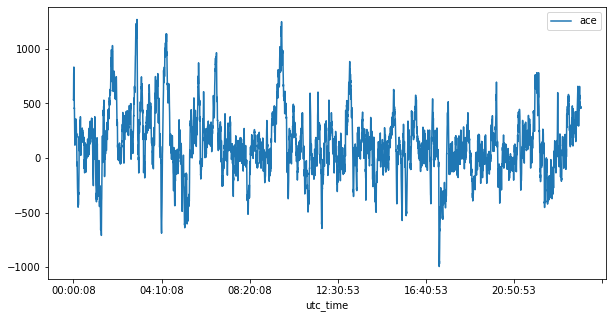

In [3]:
ace = ace0[['datetime_beginning_utc', 'ace_mw']].copy()
ace.columns = ['utc_time', 'ace']
ace = ace[ace["utc_time"].str[:3] == '6/1'].copy()

ace["utc_time"] = pd.to_datetime(ace["utc_time"]).dt.strftime('%H:%M:%S')
# ace["utc_time"] = ace["utc_time"].dt.strftime('%H:%M:%S')

ace.sort_values(by="utc_time", inplace=True)
ace.reset_index(inplace=True, drop=True)

ace.plot(y='ace', x='utc_time', figsize=(10, 5))

<AxesSubplot:xlabel='time'>

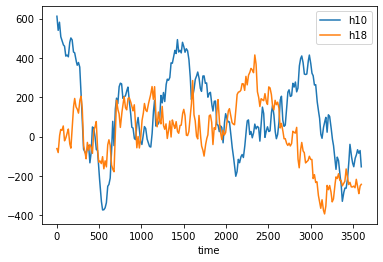

In [4]:
# interpolate ACE to 3600s with 1s interval

aces = pd.DataFrame()
aces['time'] = list(range(0, 3610, 15))  # the den should be the poitns within an hour
aces['h10'] = ace['ace'].iloc[2400:2400+aces.shape[0]].values
aces['h18'] = ace['ace'].iloc[4320:4320+aces.shape[0]].values

af10 = interp1d(aces['time'], aces['h10'])
af18 = interp1d(aces['time'], aces['h18'])

asyn = pd.DataFrame()
asyn['time'] = range(3600)
asyn['h10'] = af10(np.array(range(3600)))
asyn['h18'] = af18(np.array(range(3600)))

asyn.plot(x='time', y=['h10', 'h18'])

<AxesSubplot:xlabel='utc_time'>

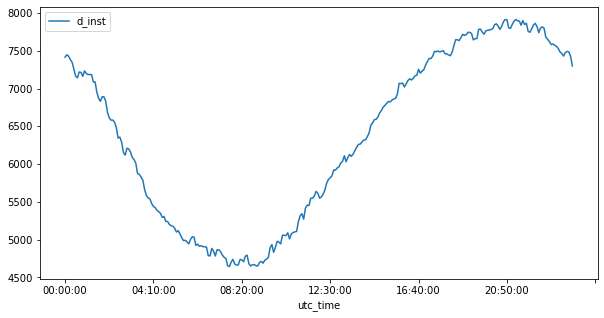

In [5]:
d_inst = load_inst[['datetime_beginning_utc', 'instantaneous_load']].copy()

d_inst.columns = ["utc_time", "d_inst"]

d_data = d_inst[d_inst["utc_time"].str[:3] == '6/1'].copy()

d_data["utc_time"] = pd.to_datetime(d_data["utc_time"])
d_data["utc_time"] = d_data["utc_time"].dt.strftime('%H:%M:%S')

d_data.sort_values(by="utc_time", inplace=True)
d_data.reset_index(inplace=True, drop=True)

d_data.plot(y='d_inst', x='utc_time', figsize=(10, 5))

<AxesSubplot:xlabel='time'>

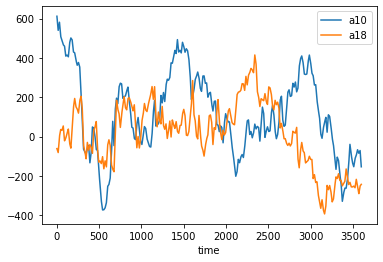

In [6]:
# Interpolate load, to (3600,)
# select a range and then interpolate it to 3600s

# 10H: 120: 132; 18H: 216: 228;

x10, x18 = 120, 216

lsyn = pd.DataFrame()
lsyn['time'] = list(range(0, 3610, int(3600/12)))  # the den should be the poitns within an hour
lsyn['h10'] = d_data['d_inst'].iloc[x10:x10+12+1].values
lsyn['h18'] = d_data['d_inst'].iloc[x18:x18+12+1].values

f10 = interp1d(lsyn['time'], lsyn['h10'])
f18 = interp1d(lsyn['time'], lsyn['h18'])

dsyn = pd.DataFrame()
dsyn['time'] = range(3600)
dsyn['h10'] = f10(np.array(range(3600)))
dsyn['h18'] = f18(np.array(range(3600)))
dsyn['a10'] = asyn['h10']
dsyn['a18'] = asyn['h18']

dsyn.plot(x='time', y=['a10', 'a18'])

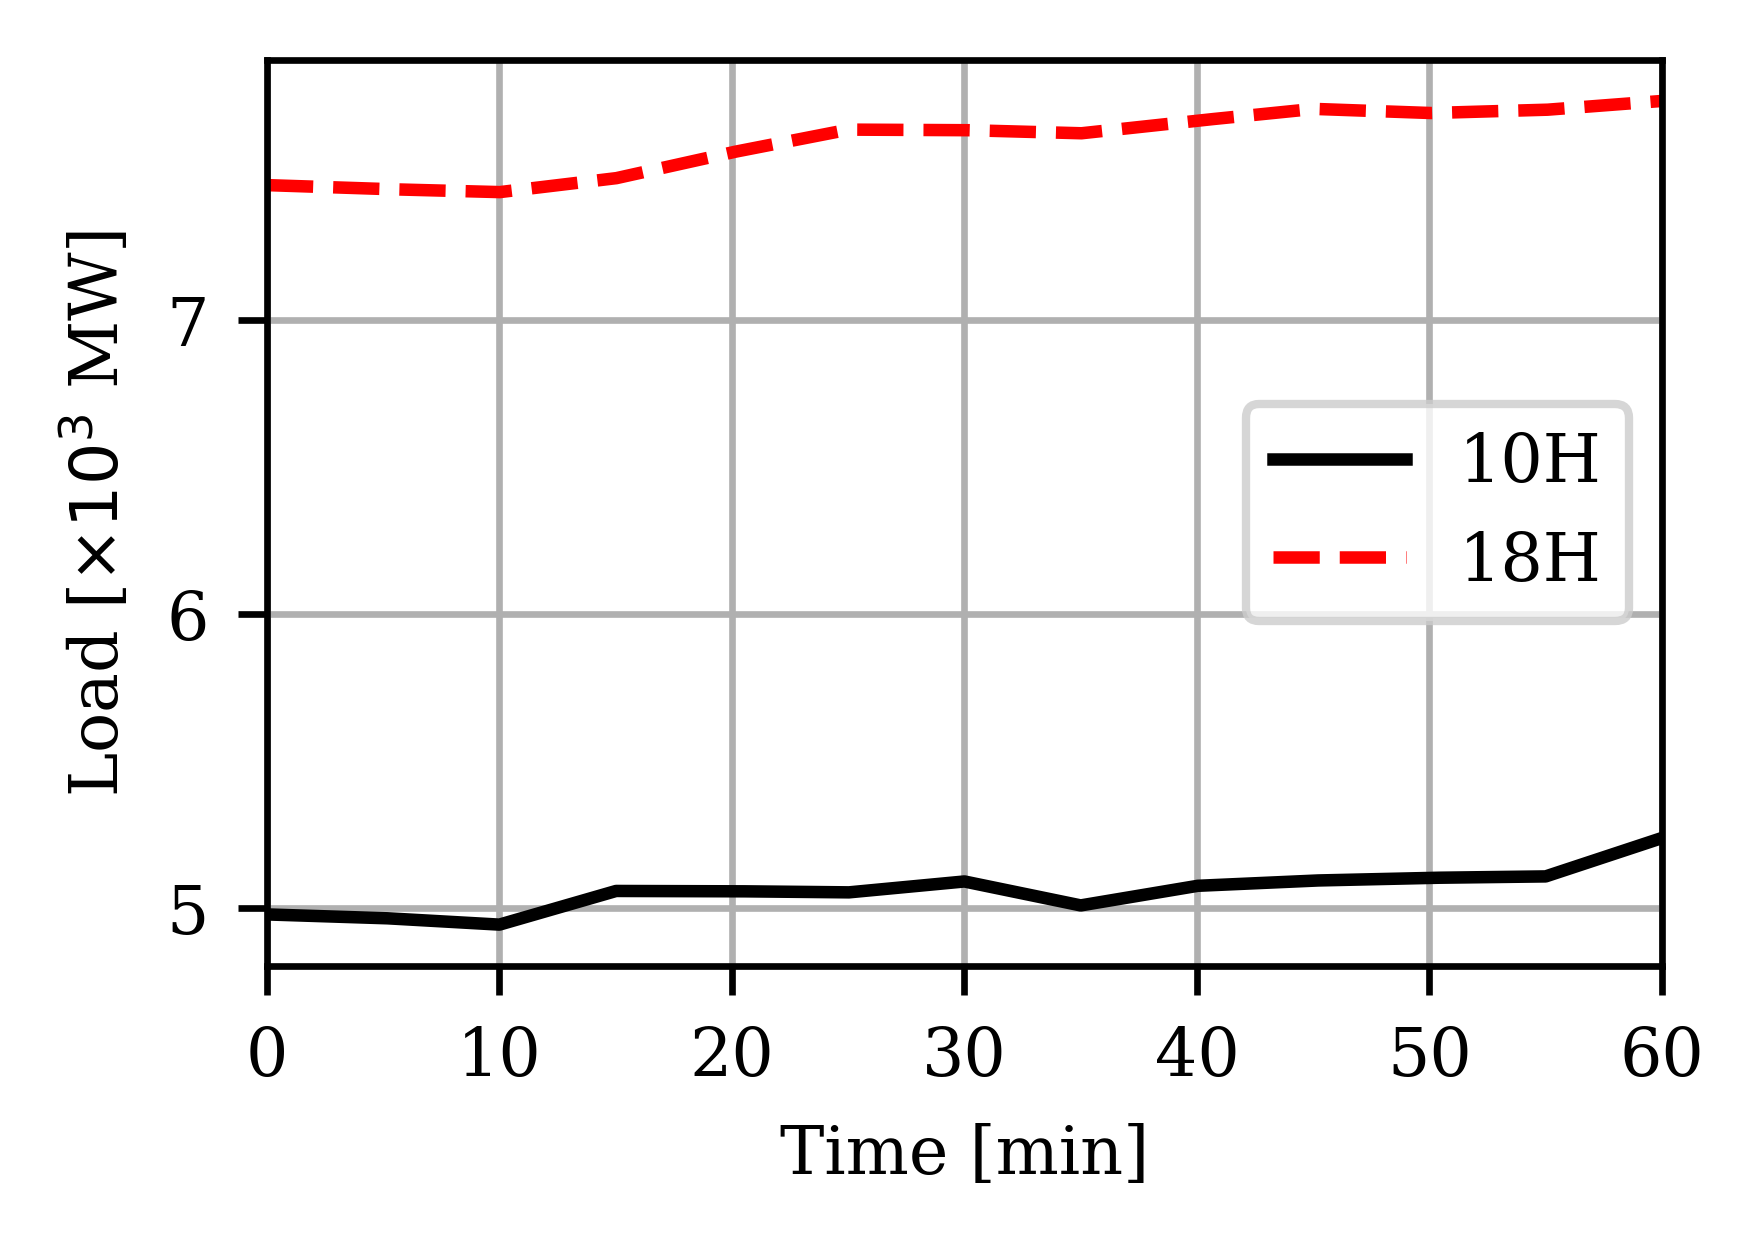

In [7]:
%matplotlib inline
with plt.style.context(['ieee']):
    fig, ax = plt.subplots(figsize=(3, 2))
    ax.plot(dsyn['time'], dsyn['h10']/1000, label="10H")
    ax.plot(dsyn['time'], dsyn['h18']/1000, label="18H")
    ax.set_ylabel(r"Load [$\times 10^3$ MW]")
    ax.set_xlabel("Time [min]")
    ax.set_xlim(0, 3600)
    ax.set_xticks(range(0, 3700, 600), range(0, 61, 10))
    ax.legend()
    ax.grid()

In [8]:
# fig.savefig('fig_loadcurve.eps', format='eps', bbox_inches='tight')

In [9]:
dsyn.to_csv(dir_path+'/case/dsyn.csv', index=False)